In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [11]:
all_features = list(raw_data.columns)
len(all_features)

680

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

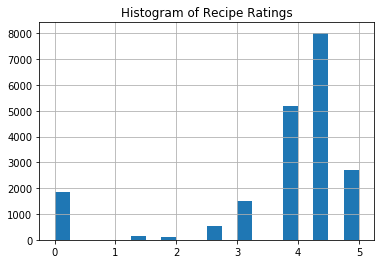

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [7]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Around 5-7 mins. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

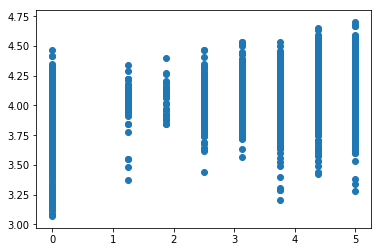

In [8]:
plt.scatter(Y, svr.predict(X))

Now that is a pretty useless visualization. This is because of the discontinous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [9]:
svr.score(X, Y)

-0.003978314483867651

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

array([-0.01787926, -0.02916288, -0.02841122, -0.03767394, -0.01735362])

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

# Challenge Begins

In [53]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.svm import SVC

### I. Creating a Binary Classifier Target Outcome

As mentioned in the beginning, this study would be useful for an author creating a cookbook and trying to decide what recipes to include that would most likely be well-received. For the purposes of this hypothetical goal, we will create a binary classifier where recipes rated at 4.375 or above will be considered desireable (or "1" in binary terms) and recipes rated below this threshold are not considered desireable (or "0"). This gives us roughly equally-sized groups in our target variable.

In [25]:
print(len(raw_data.rating[raw_data['rating'] >= 4.375]))
print(len(raw_data.rating[raw_data['rating'] < 4.375]))
raw_data.rating.unique()

10738
9314


array([2.5  , 4.375, 3.75 , 5.   , 3.125, 1.875, 0.   , 1.25 ])

In [42]:
# Creating a new dataframe with binary target variable
df = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
df['target'] = np.where(raw_data.rating >= 4.375, 1, 0)

### II. Consolidate Features (30 most valuable features)
#### A. Univariate Selection with SelectKBest (Chi-Squared)

In [83]:
X = df.drop('target', 1)
y = df['target'] 

# SelectKBest to extract 50 best features
features_kbest = SelectKBest(score_func=chi2, k=50)
fit = features_kbest.fit(X,y)
scores = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(X.columns)

# Concatenate two dataframes for better visualization 
kbest_scores = pd.concat([columns,scores],axis=1)
kbest_scores.columns = ['Specs','Score'] 
ordered_kbest = kbest_scores.nlargest(50,'Score')
print(ordered_kbest.reset_index(drop=True))

                Specs       Score
0      house & garden  168.736737
1               drink  130.854678
2           alcoholic  114.406372
3         bon appétit  100.806123
4                 gin  100.128167
5               roast   87.120913
6        thanksgiving   83.703405
7      cocktail party   76.283693
8              dinner   67.082465
9              spirit   64.501838
10          christmas   56.284523
11            bitters   55.865868
12           soy free   51.798720
13        peanut free   50.641030
14     grill/barbecue   49.678538
15            low fat   46.345607
16       backyard bbq   43.456861
17           cocktail   41.317475
18               fall   36.940820
19              grill   35.906342
20  stuffing/dressing   35.891319
21      harpercollins   35.737446
22              pasta   35.436904
23                rum   34.444240
24        goat cheese   33.527695
25      tree nut free   29.899705
26           stir-fry   29.136072
27              vegan   28.338021
28       fathe

#### B. Feature Importance with Extra Trees Classifier

In [84]:
model = ExtraTreesClassifier()
model.fit(X,y)

features_trees = pd.DataFrame(X.columns, columns=['Specs'])
features_trees['Score'] = model.feature_importances_

ordered_treeclassifier = features_trees.nlargest(50,'Score')
print(ordered_treeclassifier.reset_index(drop=True))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


                Specs     Score
0        quick & easy  0.013525
1         bon appétit  0.012239
2              summer  0.011382
3                bake  0.011261
4              winter  0.011081
5             gourmet  0.010593
6                fall  0.009338
7               onion  0.009108
8                herb  0.008546
9              spring  0.008346
10         milk/cream  0.008335
11             tomato  0.008231
12             garlic  0.008133
13          vegetable  0.008033
14       kid-friendly  0.008009
15              sauté  0.007970
16                egg  0.007845
17            healthy  0.007772
18  wheat/gluten-free  0.007614
19         vegetarian  0.007460
20              dairy  0.007460
21              fruit  0.007077
22               side  0.006580
23              lemon  0.006531
24             ginger  0.006455
25              chill  0.006147
26    kidney friendly  0.005921
27             citrus  0.005886
28             dinner  0.005825
29              sauce  0.005820
30      

#### C. Merging Insights from Both Feature Selection Methods

In [134]:
# Merging the seven features that overlap
merged_features = ordered_kbest.merge(ordered_treeclassifier, how='inner', on='Specs')

best15_kbest = ordered_kbest.iloc[:15,:]
best14_trees = ordered_treeclassifier.iloc[:14,:]

merged_features = merged_features.append(best15_kbest).drop_duplicates('Specs')
merged_features = merged_features.append(best14_trees).drop_duplicates('Specs')

best_features = list(merged_features.Specs)

### III. Testing the Model with 30 Features
#### A. Using the Best Features from Both Selection Methods

In [140]:
new_X = df[best_features]
y # = df['target'] 

svr.fit(new_X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [142]:
svr.score(new_X, y)

-0.1377018509924468

In [143]:
cross_val_score(svr, new_X, y, cv=5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

array([-0.16125721, -0.14545746, -0.1655676 , -0.16687111, -0.15547351])

#### B. Using the Best Features from SelectKBest Method

In [152]:
best_30_kbest = list(ordered_kbest.iloc[:30,:].Specs)

new_X = df[best_30_kbest]
y # = df['target'] 

svr.fit(new_X, y)

cross_val_score(svr, new_X, y, cv=5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

array([-0.17459752, -0.13355313, -0.14252552, -0.2093981 , -0.12044203])

#### C. Using the Best Features from Extra Trees Method

In [154]:
best_30_trees = list(ordered_treeclassifier.iloc[:30,:].Specs)

new_X = df[best_30_trees]
y # = df['target'] 

svr.fit(new_X, y)

cross_val_score(svr, new_X, y, cv=5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

array([-0.18000274, -0.1777393 , -0.17699194, -0.18880255, -0.17048011])

#### D. Conclusions
The three methods of feature selection all provided similarly poor results. Upon inspection, it might be that there is not enough difference between the two target variables. To see if this is the case, we will lower the target threshold to 3.75 where there seems to be a substantial break in ratings. This will not give equal distribution to both sides, but it may help distinguish the better recipes from the poor ones.

In [159]:
print(len(raw_data.rating[raw_data['rating'] >= 3.75]))
print(len(raw_data.rating[raw_data['rating'] < 3.75]))

15907
4145


In [160]:
df['new_target'] = np.where(raw_data.rating >= 3.75, 1, 0)

In [163]:
model = ExtraTreesClassifier()
model.fit(X,y)

new_features_trees = pd.DataFrame(X.columns, columns=['Specs'])
new_features_trees['Score'] = model.feature_importances_

new_ordered_treeclassifier = features_trees.nlargest(50,'Score')

new_best_30_kbest = list(new_ordered_treeclassifier.iloc[:30,:].Specs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [164]:
# Using the Extra Trees Feature Importance results because they provided the stable consistency (lowest variance)
new_X = df[new_best_30_kbest]
new_y = df['new_target'] 

svr.fit(new_X, new_y)

cross_val_score(svr, new_X, new_y, cv=5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

array([-0.06035269, -0.07193206, -0.06135104, -0.07140063, -0.07789332])

#### E. Just To Make Sure We're Not Going Crazy...

In [165]:
from sklearn.ensemble import RandomForestClassifier

In [166]:
rfc = RandomForestClassifier()
rfc.fit(new_X, new_y)
cross_val_score(rfc, new_X, new_y, cv=5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.77736225, 0.77262528, 0.77206983, 0.77381546, 0.77431421])

Good. We are not crazy.

### IV. What Are Some Reasons This Dataset May Be Biased?

In experiments, bias refers to anything that causes a sample to systematically differ from the population. Reviewing, the four different kinds of bias are: 
1. **Sampling bias**, or the selection bias
2. **Bias in assignment to conditions** procedure
3. **Contextual bias**
4. **Observer bias**
